In [9]:
import xarray as xr #Similar ao pandas mas com melhor eficiencia para trabalhar com matrizes multidimensionais, muito bom para dados georref
import numpy as np
from scipy.stats import weibull_min
from py_wake.site.xrsite import XRSite
from py_wake.site.shear import PowerShear
import matplotlib.pyplot as plt
from py_wake.flow_map import XYGrid, YZGrid, XZGrid
from pyproj import Proj, Transformer
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients
import topfarm

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from py_wake.wind_turbines import WindTurbine, WindTurbines

In [11]:
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd

u= [0,3,5,7,9,11,13,15,17,19,21]
ct= [0,8/9,8/9,8/9,8/9,8/9,8/9,8/9,8/9,8/9,8]
power= [0,0,0,0,0,0,49, 127, 224, 339, 480]

turbina= WindTurbine(name='MyWT',
                    diameter=136,
                    hub_height=100,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))

In [12]:
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

In [13]:
maior_f= f.index(max(f))

In [14]:
maior_f

8

In [23]:
valor_A= A[maior_f]
valor_k= k[maior_f]

In [25]:
valor_A

11.399

In [26]:
valor_k

2.471

In [15]:
Weibull_A = np.array(A)
Weibull_k = np.array(k)
#Configura o  Turbulence intensity - TI, e 
#ti = 0.1 # Desvio padrão da velocidade do vento / Velocidade média do vento
#Gera o vetor de direção "referencia"

site_1 = xr.Dataset(
    data_vars={
        'Sector_frequency': ('wd', f),
        'Weibull_A': ('wd', Weibull_A),
        'Weibull_k': ('wd', Weibull_k),
        'TI': (ti)   #colocar uma lista
    },
    coords={
        'wd': wd,
    }
)

In [16]:
from py_wake import NOJ
windTurbines = turbina
site = XRSite(site_1)


In [17]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.superposition_models import MaxSum, WeightedSum
from py_wake.deficit_models import BastankhahGaussianDeficit, FugaDeficit, NiayifarGaussianDeficit

wf_model = All2AllIterative(site, turbina,
                            wake_deficitModel=FugaDeficit(),
                            superpositionModel=MaxSum(),
                            blockage_deficitModel=FugaDeficit())

In [18]:
# Create a 10x10 grid with 2000m spacing between each element
#grid_size = 10
#spacing = 2000

#x_grid = np.arange(grid_size) * spacing
#y_grid = np.arange(grid_size) * spacing

#layout_x, layout_y = np.meshgrid(x_grid, y_grid)
#layout_x = layout_x.reshape(-1)
#layout_y = layout_y.reshape(-1)

layout_x=[420, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]
layout_y=[0,210,410,610,810,1010,1210,1410,1610,1810]

In [19]:
import time
start_time = time.perf_counter_ns()
simulaçaoResult = wf_model(layout_x, layout_y, wd=150, ws=[10])
end_time = time.perf_counter_ns()
elapsed_time = end_time - start_time
print(f"Tempo de execução: {elapsed_time}")

Tempo de execução: 47458200


In [20]:
simulaçaoResult

<xarray.SimulationResult> Size: 816B
Dimensions:           (wt: 10, wd: 1, ws: 1)
Coordinates:
  * wt                (wt) int64 80B 0 1 2 3 4 5 6 7 8 9
  * wd                (wd) int64 8B 150
  * ws                (ws) int64 8B 10
    type              (wt) int64 80B 0 0 0 0 0 0 0 0 0 0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 80B 9.958 9.748 9.988 ... 9.988 10.0
    TI_eff            (wt, wd, ws) float64 80B 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 80B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CT                (wt, wd, ws) float64 80B 0.8889 0.8889 ... 0.8889 0.8889
    h                 (wt) float64 80B 100.0 100.0 100.0 ... 100.0 100.0 100.0
    x                 (wt) int64 80B 420 200 400 600 800 ... 1200 1400 1600 1800
    ...                ...
    ws_l              float64 8B 9.5
    ws_u              float64 8B 10.5
    Weibull_A         float64 8B 9.594
    Weibull_k         float64 8B 2.596
    Sector_frequency  float64 8B 0.768
    P                 float64 8B 0.07277

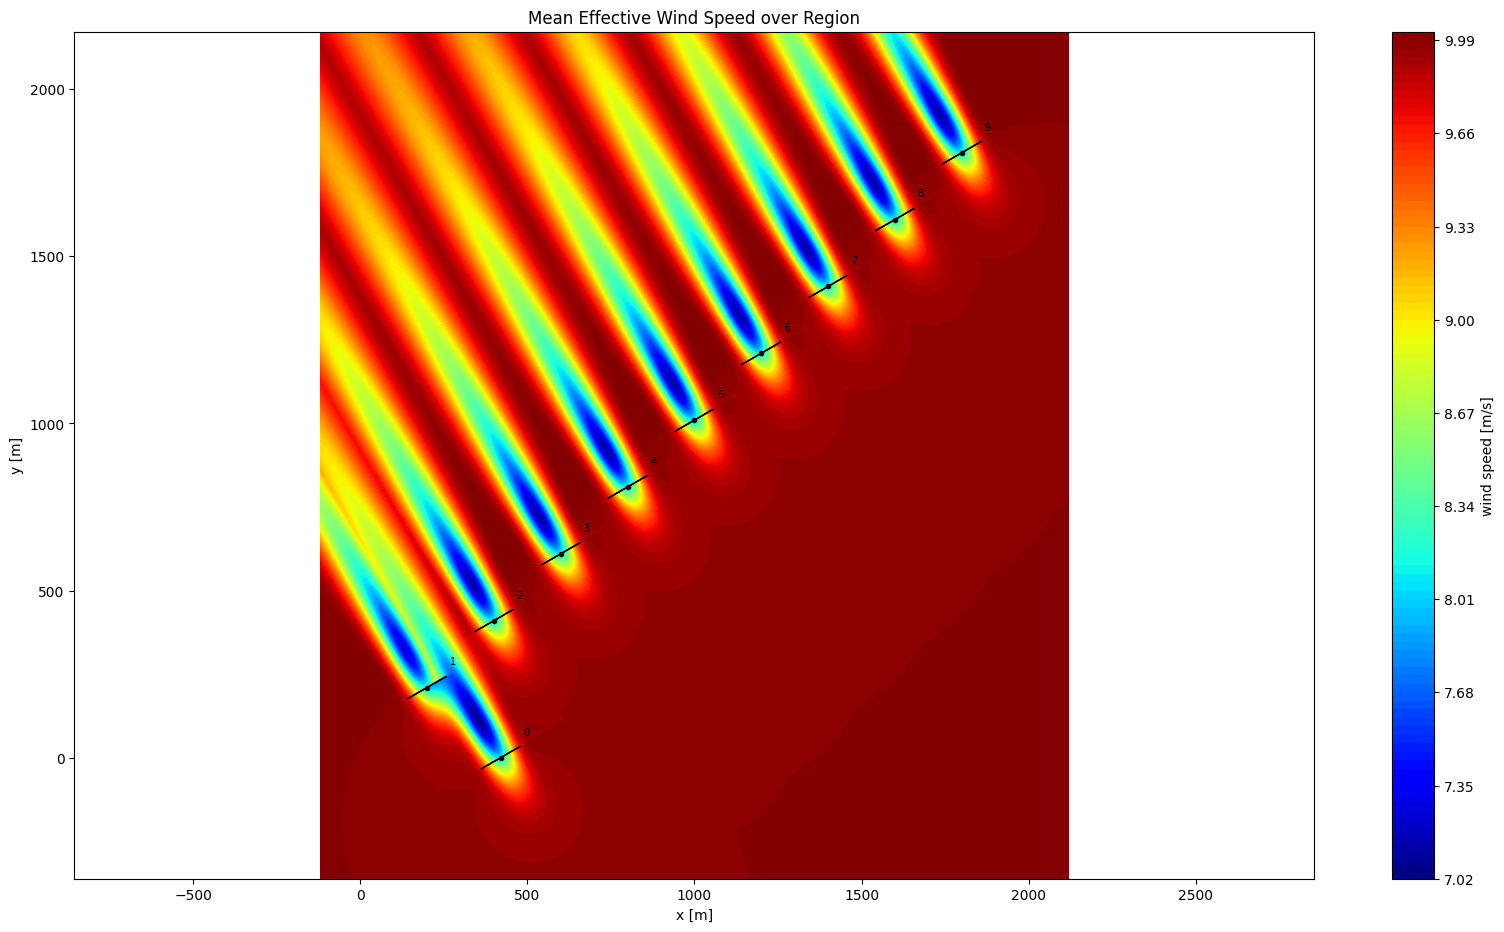

Tempo de execução: 5442862900


In [21]:
start_time = time.perf_counter_ns()
flow = simulaçaoResult.flow_map()
plt.figure(figsize=(20, 11))
flow.plot_wake_map(cmap='jet')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mean Effective Wind Speed over Region')
plt.show()
end_time = time.perf_counter_ns()
elapsed_time = end_time - start_time
print(f"Tempo de execução: {elapsed_time}")